In [ ]:
# Texas Luminescense Fall 2023 Project - Illness Predictor
# Authors: Aniket Gupta, Minjae Cho, Arjun Kumar, Advik Sundar

# Source Data: https://www.kaggle.com/datasets/andrewmvd/isic-2019

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import pickle
import keras_tuner as kt


In [ ]:
print("GPU", "available " if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [ ]:
training_truth = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv"
training_mdata = "/content/drive/MyDrive/ISIC_2019_Training_Metadata.csv"

truth_df = pd.read_csv(training_truth)
mdata_df = pd.read_csv(training_mdata)

merged_df = pd.merge(truth_df, mdata_df, on="image")

print(merged_df)

              image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  age_approx  \
0      ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        55.0   
1      ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0   
2      ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        60.0   
3      ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0   
4      ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        80.0   
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...         ...   
25326  ISIC_0073247  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0        85.0   
25327  ISIC_0073248  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0        65.0   
25328  ISIC_0073249  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        70.0   
25329  ISIC_0073251  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        55.0   
25330  ISIC_0073254  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0        50.0   

      anatom_site_general  

In [ ]:
melted_df = pd.melt(merged_df, id_vars=['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'],
                    var_name='disease', value_name='diagnosis')

melted_df = melted_df[melted_df['diagnosis'] == 1.0]
melted_df = melted_df.drop(columns='diagnosis') # redundant

In [ ]:
# melted_df.head(1000)

lesion_id_list = list(melted_df['lesion_id'].unique())

nonull_df = melted_df.dropna(subset=['lesion_id'])


In [ ]:
print(nonull_df.describe())
print(nonull_df.head(10000))

         age_approx
count  23120.000000
mean      54.735943
std       17.782239
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max       85.000000
                          image  age_approx anatom_site_general     lesion_id  \
1482   ISIC_0012678_downsampled        70.0           head/neck  MSK4_0010037   
1497   ISIC_0012701_downsampled        70.0       lateral torso  MSK4_0011210   
1507   ISIC_0012715_downsampled        80.0           head/neck  MSK4_0010733   
1522   ISIC_0012749_downsampled        85.0           head/neck  MSK4_0010960   
1523   ISIC_0012756_downsampled        55.0      anterior torso  MSK4_0010029   
...                         ...         ...                 ...           ...   
36053              ISIC_0032125        25.0     lower extremity   HAM_0003305   
36054              ISIC_0032126        50.0     posterior torso   HAM_0000045   
36055              ISIC_0032127        70.0     lower extremity   HAM_0001595   
36058     

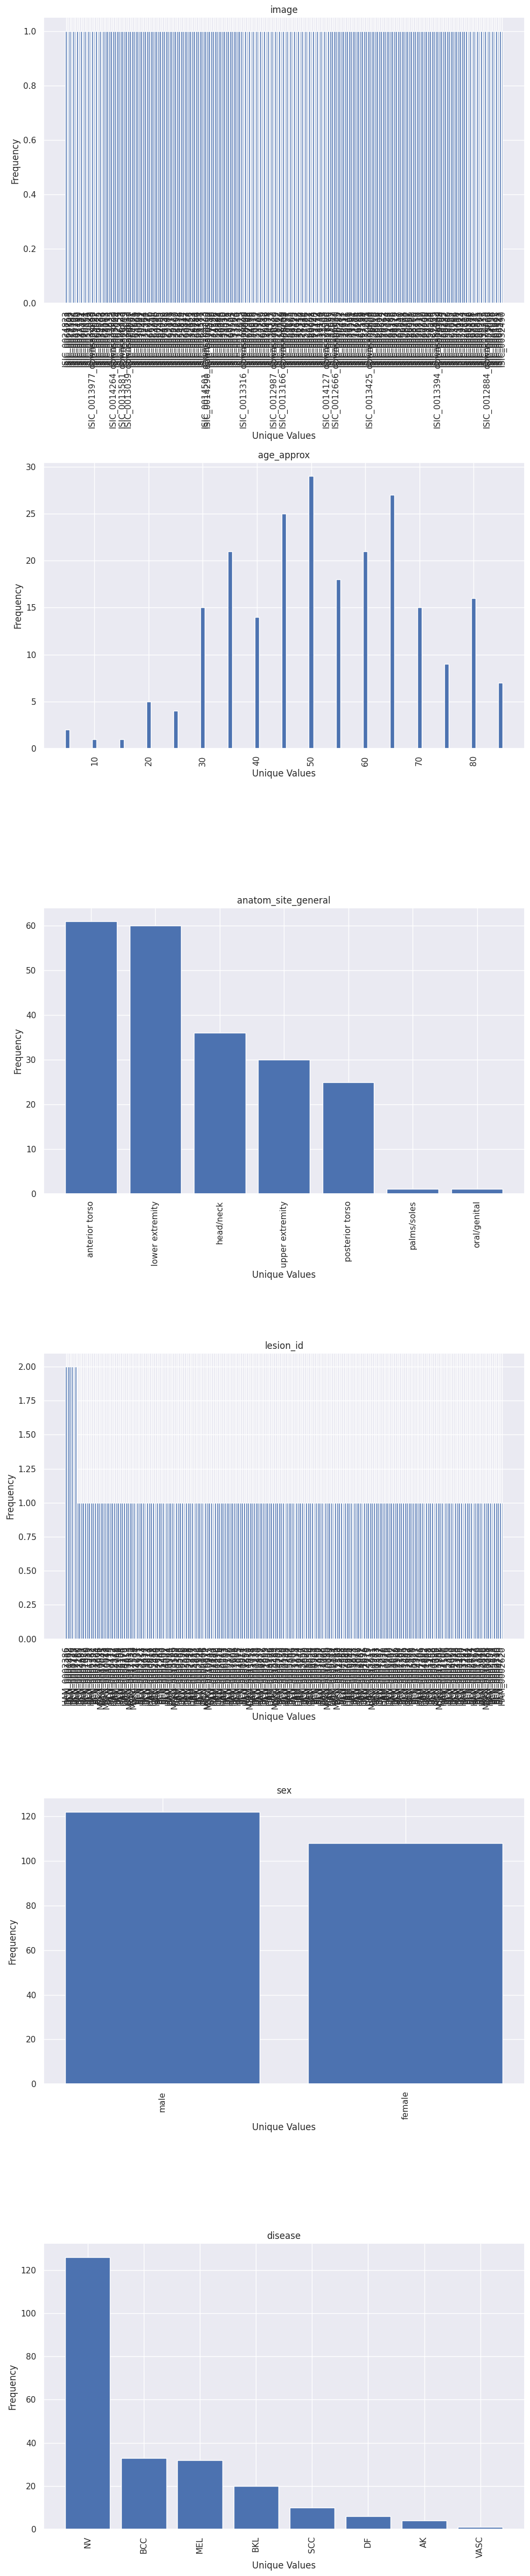

In [ ]:
df = nonull_df.sample(frac=0.01, random_state=42)

# Get the list of column names
cols = df.columns
n_cols = len(cols)

# Set up subplots
fig, axes = plt.subplots(n_cols, 1, figsize=(10, 8 * n_cols))

# Iterate through each column and plot the frequencies
for i, column in enumerate(cols):
    value_counts = df[column].value_counts()
    axes[i].bar(value_counts.index, value_counts.values)
    axes[i].set_title(column)
    axes[i].set_xlabel('Unique Values')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# NOTE - HIGH FREQ OF NV DATA RELATIVE TO OTHER DISEASES - LOOK OUT FOR DATA SPARSITY EFFECTS ON OTHERS

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image
from matplotlib.pyplot import imread
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "GPU Running" if tf.config.list_physical_devices("GPU") else "not available :(")

TF Hub version: 0.15.0
GPU not available :(


In [ ]:
labels_df = nonull_df[['image', 'disease']]

In [ ]:
labels_df

,image,disease
1482,ISIC_0012678_downsampled,MEL
1497,ISIC_0012701_downsampled,MEL
1507,ISIC_0012715_downsampled,MEL
1522,ISIC_0012749_downsampled,MEL
1523,ISIC_0012756_downsampled,MEL
...,...,...
202498,ISIC_0073022,SCC
202503,ISIC_0073030,SCC
202541,ISIC_0073088,SCC
202606,ISIC_0073195,SCC


<Axes: >

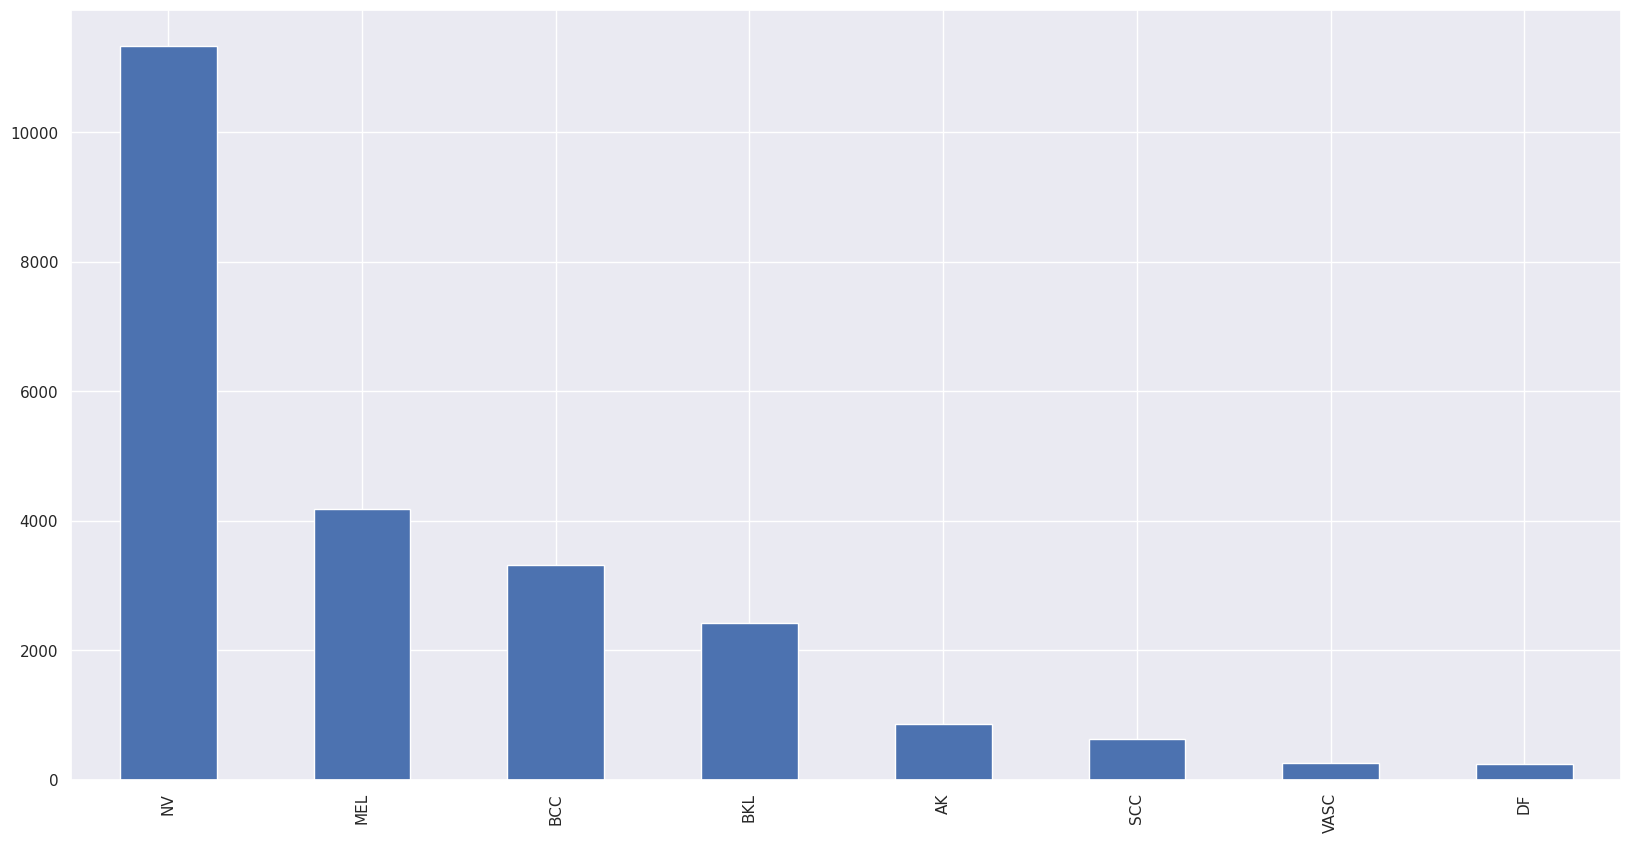

In [ ]:
labels_df["disease"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
filenames = ["drive/My Drive/ISIC_2019_Training_Input/" + fname + ".jpg" for fname in labels_df["image"]]

filenames[:10]

['drive/My Drive/ISIC_2019_Training_Input/ISIC_0012678_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012701_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012715_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012749_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012756_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012758.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012887_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012930_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012988_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012989_downsampled.jpg']

In [ ]:
labels = labels_df["disease"].to_numpy()

In [ ]:
unique_types = np.unique(labels)
len(unique_types)

8

In [ ]:
#structure data so that there is one "true" value associated with one of the headers (unique types)
boolean_labels = [label == unique_types for label in labels]
boolean_labels[:2]

[array([False, False, False, False,  True, False, False, False]),
 array([False, False, False, False,  True, False, False, False])]

##Image preprocessing

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

#TODO: can u chain
def process_image(image_path, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_WIDTH, IMG_HEIGHT])

  return image

In [ ]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [ ]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  #No labels
  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  #yay we have labels
  elif valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  #labels but shuffle
  #TODO do we need to shuffle
  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)


  return data_batch

In [ ]:
X = filenames
y = boolean_labels
len(X)

23247

In [ ]:
IMAGES_USED = 1000
IMAGE_TRAIN_SPLIT = 0.7
IMAGE_TEST_SPLIT = 0.1

#0.2, 0.1, 0.7
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-IMAGE_TRAIN_SPLIT, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=IMAGE_TEST_SPLIT/(1-IMAGE_TRAIN_SPLIT), random_state=42)


In [ ]:
#make into tensors
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

useful stuff

In [ ]:
INPUT_SHAPE = [None, IMG_WIDTH, IMG_HEIGHT, 3] # batch, height, width, colour channels
OUTPUT_SHAPE = len(unique_types)
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1"

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax")
  ])

  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy', 'mse', 'mae'] #TODO: 'rmse', 'roc_auc'
  )

  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 8)                 8016      
                                                                 
Total params: 5440729 (20.75 MB)
Trainable params: 8016 (31.31 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [ ]:
%load_ext tensorboard
import datetime

def create_tensorboard_callback():
  logdir = os.path.join("drive/My Drive/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)
early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

In [ ]:
def tuner():
  tuner = kt.Hyperband(model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuner',
                     project_name='skin_detection')
  tuner.search(train_data, epochs=50, validation_split=0.2, callbacks=[early_stopping_loss])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
  is {best_hps.get('learning_rate')}.
  """)
  new_model = tuner.hypermodel.build(best_hps)
  return new_model

In [ ]:
NUM_EPOCHS = 10

def train_model():
  """
  Trains a given model and returns the trained version.
  """
  model = create_model()

  tensorboard = create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  #ADD BACK early_stopping to callbacks
  return model

In [ ]:
# model = train_model() DONT RUN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 8)                 8016      
                                                                 
Total params: 5440729 (20.75 MB)
Trainable params: 8016 (31.31 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [ ]:
%tensorboard --logdir drive/My Drive/logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-11-28 20:41:30.873581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 20:41:30.873661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 20:41:30.873697: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 20:41:32.432561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--loa

In [ ]:
def save_model(model, ending="", typee=".keras"):
  modeldir = os.path.join("drive/My Drive/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + ending + typee
  model.save(model_path)
  return model_path

In [ ]:
def load_model(path, typee=".keras"):
  new_model = tf.keras.models.load_model(path)
  return new_model

In [ ]:
# save_model(model, typee="first-attempt-100")
model = load_model("drive/My Drive/models/20231128-03061701140802-first-attempt-100") #RUN THIS OR THE ABOVE COMMENTED LINE


In [ ]:
def most_likely(probs):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_types[np.argmax(probs)]
def unbatchify(data):
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(most_likely(label))
  return images, labels

In [ ]:
predictions = model.predict(val_data)
val_images, val_labels = unbatchify(val_data)

73/73 [==============================] - 622s 7s/step


In [ ]:
def plot_pred_conf(ax, pred_prob, true_label):
  top_3_pred_indexes = pred_prob.argsort()[-8:][::-1]
  top_3_pred_values = pred_prob[top_3_pred_indexes]
  top_3_pred_labels = unique_types[top_3_pred_indexes]

  top_plot = ax.bar(np.arange(len(top_3_pred_labels)),
                     top_3_pred_values,
                     color="grey") #Todo add title
  ax.set_xticks(np.arange(len(top_3_pred_labels)),
             labels=top_3_pred_labels,
             rotation="vertical")
  if np.isin(true_label, top_3_pred_labels):
    top_plot[np.argmax(top_3_pred_labels == true_label)].set_color("green")
  else:
    pass

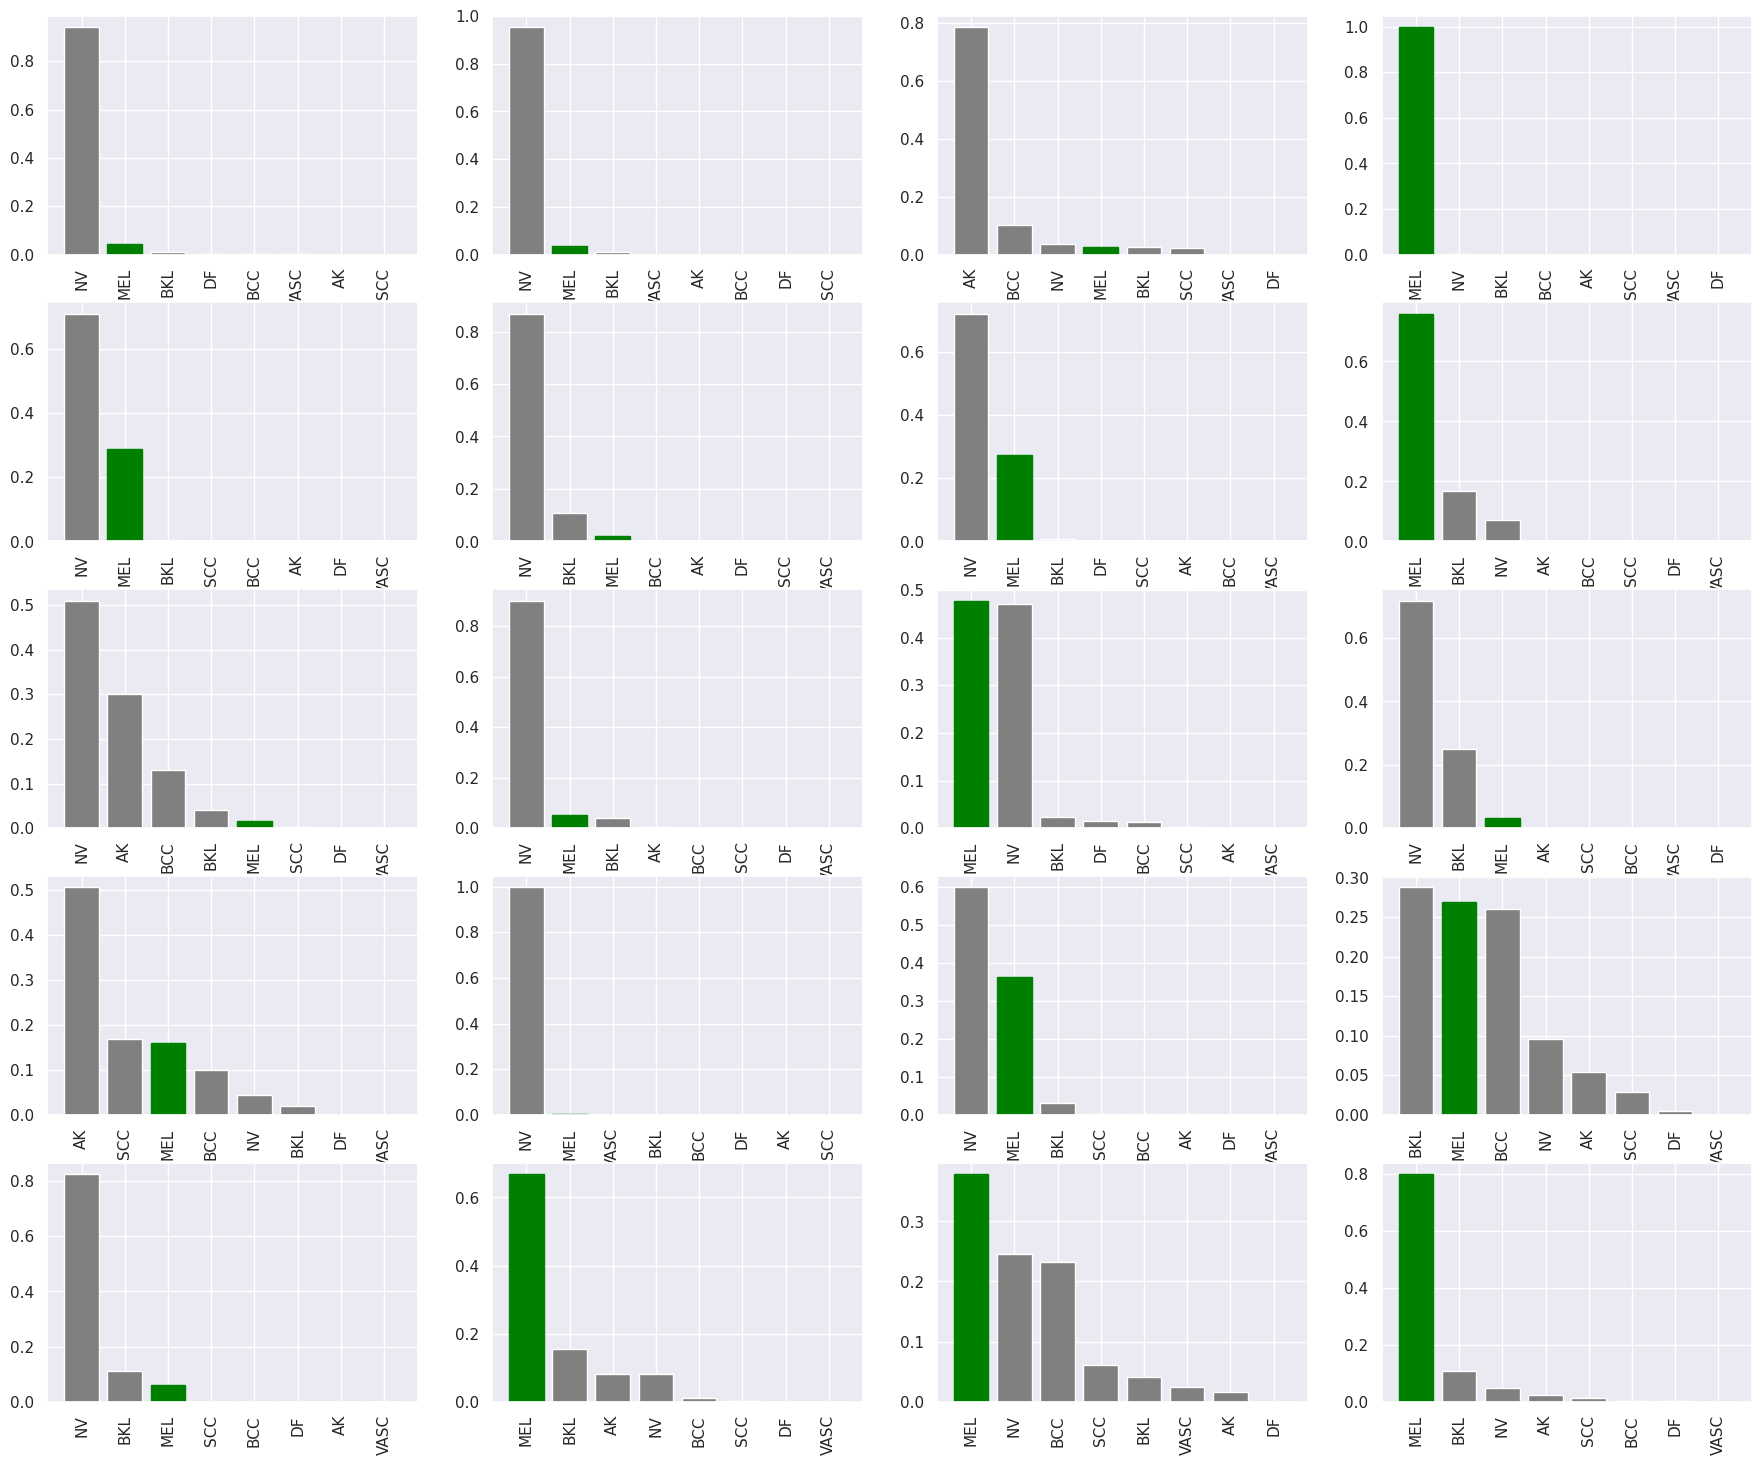

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(22, 18))
axs = axs.flatten()

j = 0;
for i in range(1000,1020):
  plot_pred_conf(axs[j], predictions[i],
                labels[i])
  j+=1

In [ ]:
model.evaluate(val_data)

73/73 [==============================] - 81s 1s/step - loss: 0.9672 - accuracy: 0.6675 - mse: 0.0575 - mae: 0.1004


[0.9672013521194458,
 0.66752690076828,
 0.05746274068951607,
 0.10040164738893509]

In [ ]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.96720135>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6675269>,
 'mse': <tf.Tensor: shape=(), dtype=float32, numpy=0.05746274>,
 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.10040165>}

In [ ]:
prediction_labels = []

for i in predictions:
  prediction_labels.append(most_likely(i))

In [ ]:
class_report = classification_report(val_labels, prediction_labels)

In [ ]:
print(class_report)

              precision    recall  f1-score   support

          AK       0.27      0.36      0.31        76
         BCC       0.73      0.51      0.60       335
         BKL       0.59      0.25      0.35       229
          DF       0.50      0.12      0.19        26
         MEL       0.59      0.53      0.56       426
          NV       0.72      0.91      0.80      1137
         SCC       0.39      0.29      0.33        70
        VASC       0.89      0.62      0.73        26

    accuracy                           0.67      2325
   macro avg       0.58      0.45      0.48      2325
weighted avg       0.66      0.67      0.65      2325



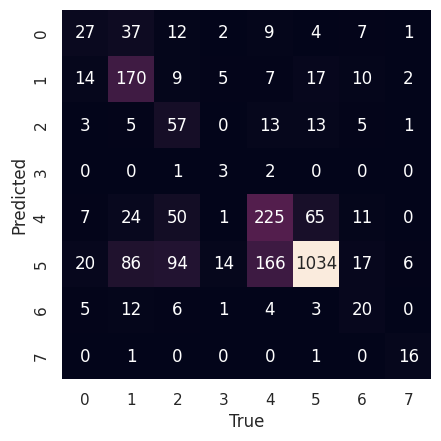

In [ ]:
c_mat = metrics.confusion_matrix(val_labels, prediction_labels)
sns.heatmap(c_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True');
plt.ylabel('Predicted');

In [ ]:
pickle.dump(model, open('dermavision_model_attempt_1.pkl', 'wb'))